<a href="https://colab.research.google.com/github/JieJerryLiu/JieJerryLiu.github.io/blob/main/Churn_modelling_Jie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Customer Churn Prediction**



*   Perform exploratory data analysis and feature engineering,
*   XGBoost has bettern preformance in customer churn prediction, compared with KNN, Logistic Regression, and Random Forest,
*   Age, active member or not, and num of products serve as the top 3 features that influence user retention.


# Part 0: Setup Google Drive Environment/Data Collection

In [1]:
# Colab environment setup
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# import data
id = "1szdCZ98EK59cfJ4jG03g1HOv_OhC1oyN"
file = drive.CreateFile({'id':id})
file.GetContentFile("churn_df.csv")

In [3]:
# import library and model

# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualizaiton
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Model support functions
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Feature analysis
from sklearn.inspection import permutation_importance
!pip install shap
import shap
shap.initjs()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [4]:
churn_df = pd.read_csv('churn_df.csv')
churn_df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

# Part 1: Exploratory Data Analysis

## Part 1.1: Understand the Raw Dataset

In [5]:
churn_df.shape

(10000, 14)

In [6]:
# note: information funciton: for tabel calculate should have (), if not count, do not use ()
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
churn_df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [8]:
!pip install -U imbalanced-learn
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 5.1 MB/s 
     |████████████████████████████████| 199 kB 62.1 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     | 21.9 MB 115 kB/s
     |████████████████████████████████| 596 kB 4.9 MB/s 
     |████████████████████████████████| 102 kB 37.4 MB/s 
     |████████████████████████████████| 690 kB 38.9 MB/s 
     |████████████████████████████████| 4.7 MB 44.1 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 812 kB 53.9 MB/s 
     |████████████████████████████████| 38.1 MB 14.7 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2

In [9]:
# EDA with pandas_profiling
from pandas_profiling import ProfileReport

ProfileReport(churn_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Get target variable

y = churn_df['Exited']

## Part 1.2: Understand the features

In [11]:
# check missing values

churn_df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [12]:
# understand Numerical feature

churn_df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts','Balance', 'EstimatedSalary']].describe().T

count           mean           std     min       25%  \
CreditScore      10000.0     650.528800     96.653299  350.00    584.00   
Age              10000.0      38.921800     10.487806   18.00     32.00   
Tenure           10000.0       5.012800      2.892174    0.00      3.00   
NumOfProducts    10000.0       1.530200      0.581654    1.00      1.00   
Balance          10000.0   76485.889288  62397.405202    0.00      0.00   
EstimatedSalary  10000.0  100090.239881  57510.492818   11.58  51002.11   

                        50%          75%        max  
CreditScore         652.000     718.0000     850.00  
Age                  37.000      44.0000      92.00  
Tenure                5.000       7.0000      10.00  
NumOfProducts         1.000       2.0000       4.00  
Balance           97198.540  127644.2400  250898.09  
EstimatedSalary  100193.915  149388.2475  199992.48

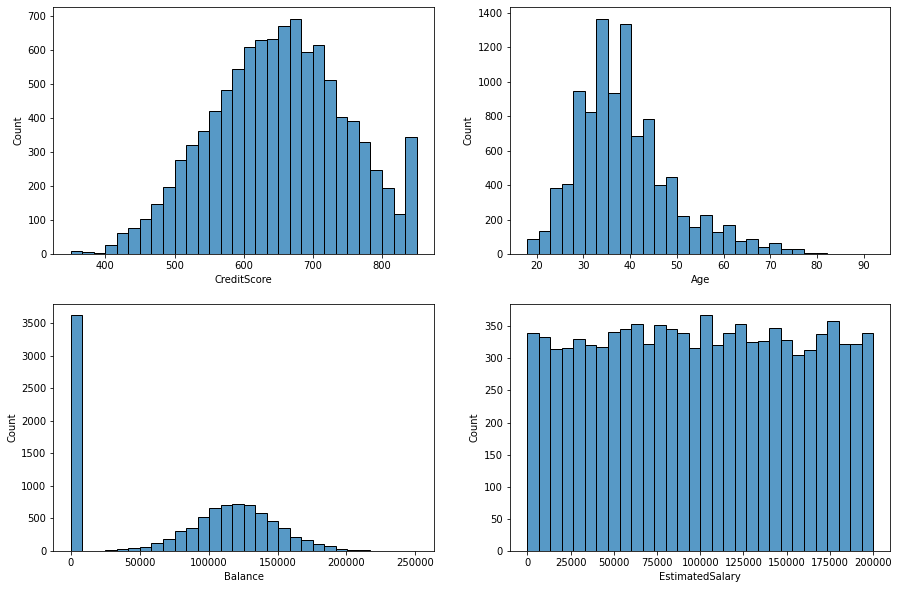

In [13]:
# distribution of numerical features

fig, axss = plt.subplots(2,2, figsize = [15, 10])
sns.histplot(x = 'CreditScore',data = churn_df, bins = 30, ax=axss[0][0])
sns.histplot(x = 'Age',data = churn_df, bins = 30, ax=axss[0][1])
sns.histplot(x = 'Balance',data = churn_df, bins = 30, ax=axss[1][0])
sns.histplot(x = 'EstimatedSalary',data = churn_df, bins = 30, ax=axss[1][1])

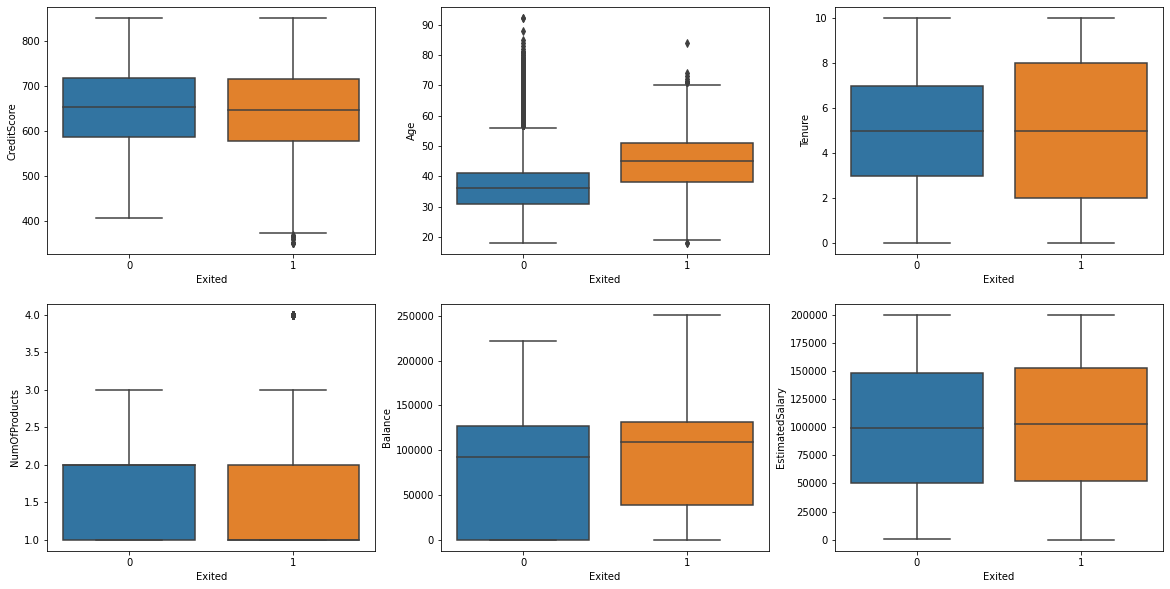

In [14]:
# boxplot for numerical feature
fig, axss = plt.subplots(2,3, figsize = [20, 10])
sns.boxplot(x='Exited', y ='CreditScore', data=churn_df, ax=axss[0][0])
sns.boxplot(x='Exited', y ='Age', data=churn_df, ax=axss[0][1])
sns.boxplot(x='Exited', y ='Tenure', data=churn_df, ax=axss[0][2])
sns.boxplot(x='Exited', y ='NumOfProducts', data=churn_df, ax=axss[1][0])
sns.boxplot(x='Exited', y ='Balance', data=churn_df, ax=axss[1][1])
sns.boxplot(x='Exited', y ='EstimatedSalary', data=churn_df, ax=axss[1][2])

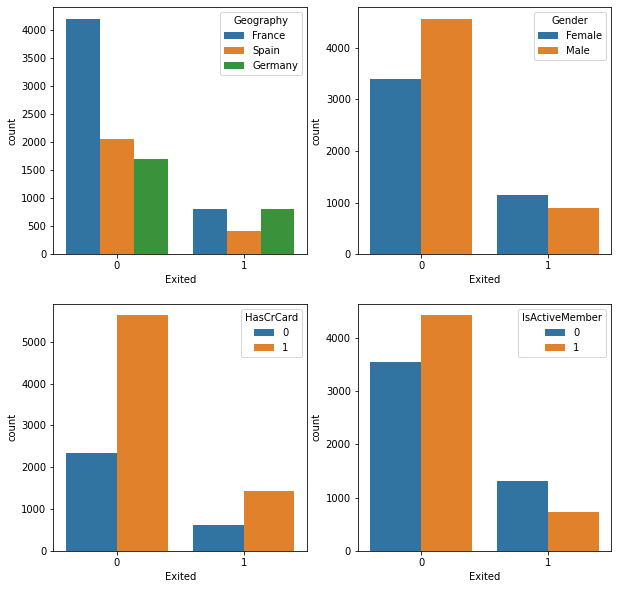

In [15]:
# understand categorical feature

fig, axss = plt.subplots(2,2,figsize=[10,10])
sns.countplot(x='Exited', hue = 'Geography', data = churn_df, ax = axss[0][0])
sns.countplot(x='Exited', hue='Gender', data=churn_df, ax=axss[0][1])
sns.countplot(x='Exited', hue='HasCrCard', data=churn_df, ax=axss[1][0])
sns.countplot(x='Exited', hue='IsActiveMember', data=churn_df, ax=axss[1][1])

# Part 2: Feature Preprocessing

In [16]:
# Get feature space by dropping useless feature

column_drop = ['RowNumber', 'CustomerId','Surname', 'Exited']
X = churn_df.drop(column_drop, axis = 1)

In [17]:
X.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               1        101348.88  
1          0               1        112542.58  
2          1               0        113931.57  
3          0               0         93826.63  
4          1               1         79084.10

In [18]:
X.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [19]:
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[(X.dtypes == 'float64')|(X.dtypes == 'int64')]

In [20]:
num_cols

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [21]:
cat_cols

Index(['Geography', 'Gender'], dtype='object')

## Part 2.1: Split dataset

In [22]:
# split data into training and testing

# Reserve 25% for testing

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 1)

print('traning data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

traning data has 7500 observation with 10 features
test data has 7500 observation with 10 features


In [23]:
X_train.head()

CreditScore Geography  Gender  Age  Tenure   Balance  NumOfProducts  \
7971          633     Spain    Male   42      10      0.00              1   
9152          708   Germany  Female   23       4  71433.08              1   
6732          548    France  Female   37       9      0.00              2   
902           645    France  Female   48       7  90612.34              1   
2996          729     Spain  Female   45       7  91091.06              2   

      HasCrCard  IsActiveMember  EstimatedSalary  
7971          0               1         79408.17  
9152          1               0        103697.57  
6732          0               0         98029.58  
902           1               1        149139.13  
2996          1               0         71133.12

In [24]:
# One hot encoding

def OneHotEncoding(df, enc, categories):
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis = 1).drop(categories, axis = 1)

categories = ['Geography']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])

X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [25]:
X_train.head()

CreditScore  Gender  Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0          633    Male   42      10      0.00              1          0   
1          708  Female   23       4  71433.08              1          1   
2          548  Female   37       9      0.00              2          0   
3          645  Female   48       7  90612.34              1          1   
4          729  Female   45       7  91091.06              2          1   

   IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0               1         79408.17               0.0                0.0   
1               0        103697.57               0.0                1.0   
2               0         98029.58               1.0                0.0   
3               1        149139.13               1.0                0.0   
4               0         71133.12               0.0                0.0   

   Geography_Spain  
0              1.0  
1              0.0  
2              0.0  
3              0.0  
4              1.0

In [26]:
# Ordinal encoding

categories = ['Gender']
enc_oe = OrdinalEncoder()
enc_oe.fit(X_train[categories])

X_train[categories] = enc_oe.transform(X_train[categories])
X_test[categories] = enc_oe.transform(X_test[categories])

In [27]:
X_train.head()

CreditScore  Gender  Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0          633     1.0   42      10      0.00              1          0   
1          708     0.0   23       4  71433.08              1          1   
2          548     0.0   37       9      0.00              2          0   
3          645     0.0   48       7  90612.34              1          1   
4          729     0.0   45       7  91091.06              2          1   

   IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0               1         79408.17               0.0                0.0   
1               0        103697.57               0.0                1.0   
2               0         98029.58               1.0                0.0   
3               1        149139.13               1.0                0.0   
4               0         71133.12               0.0                0.0   

   Geography_Spain  
0              1.0  
1              0.0  
2              0.0  
3              0.0  
4              1.0

## Part 2.2: Standardize

In [28]:
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [29]:
X_train.head()

CreditScore  Gender       Age    Tenure   Balance  NumOfProducts  \
0    -0.172985     1.0  0.289202  1.731199 -1.218916      -0.912769   
1     0.602407     0.0 -1.509319 -0.341156 -0.076977      -0.912769   
2    -1.051762     0.0 -0.184093  1.385806 -1.218916       0.796109   
3    -0.048922     0.0  0.857156  0.695022  0.229625      -0.912769   
4     0.819517     0.0  0.573179  0.695022  0.237278       0.796109   

   HasCrCard  IsActiveMember  EstimatedSalary  Geography_France  \
0  -1.542199        0.968496        -0.352044               0.0   
1   0.648425       -1.032529         0.072315               0.0   
2  -1.542199       -1.032529        -0.026711               1.0   
3   0.648425        0.968496         0.866221               1.0   
4   0.648425       -1.032529        -0.496617               0.0   

   Geography_Germany  Geography_Spain  
0                0.0              1.0  
1                1.0              0.0  
2                0.0              0.0  
3                0.0              0.0  
4                0.0              1.0

# Part 3: Model Training and Result Evaluation

## Part 3.1: Model Training

In [30]:
# Logistic Regression
classifier_logistic = LogisticRegression()

# k Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

# XGBoost
classifier_XGB = XGBClassifier()

# Neural Network
classifier_mlp = MLPClassifier()

In [31]:
# use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest', 'XGBoost', 'Neural Network']
model_list = [classifier_logistic, classifier_KNN, classifier_RF, classifier_XGB, classifier_mlp]
count = 0

for classifier in model_list:
  cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv = 5)
  print(cv_score)
  print("Model accuracy of " + model_names[count] + ' is ' + str(cv_score.mean()) + "\n")
  count += 1


[0.81933333 0.80666667 0.80666667 0.80933333 0.82      ]
Model accuracy of Logistic Regression is 0.8124

[0.84133333 0.84066667 0.83       0.83066667 0.84      ]
Model accuracy of KNN is 0.8365333333333334

[0.87733333 0.86466667 0.85533333 0.85866667 0.866     ]
Model accuracy of Random Forest is 0.8644000000000001

[0.87666667 0.862      0.854      0.86533333 0.86533333]
Model accuracy of XGBoost is 0.8646666666666667



Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[0.86266667 0.85733333 0.84733333 0.85733333 0.86333333]
Model accuracy of Neural Network is 0.8576



Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


## Part 3.2: Use Grid Search to Find Optimal Hyperparameters

In [32]:
# helper function for printing out grid search results
def print_grid_search_metrics(gs):
  print("Best score: " + str(gs.best_score_))
  print("Best parameters set: ")
  best_parameters = gs.best_params_
  for param_name in sorted(best_parameters.keys()):
    print(param_name + ':' + str(best_parameters[param_name]))

### `Part 3.2.1: Find Optimal Hyperparamters - LogisticRegression`

In [33]:
parameters = {
    'penalty':['l2', 'l1'], 
    'C':(0.01, 0.05, 0.1, 0.2, 1, 2, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': (0.01, 0.05, 0.1, 0.2, 1, 2, 5, 10),
                         'penalty': ['l2', 'l1']})

In [34]:
# the best hyperparameter combination

print_grid_search_metrics(Grid_LR)

Best score: 0.8125333333333333
Best parameters set: 
C:1
penalty:l1


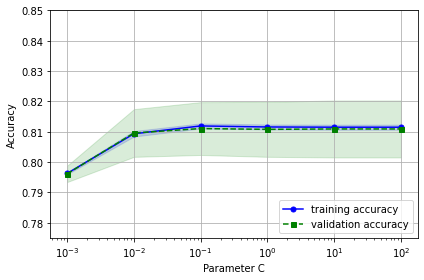

In [35]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=LogisticRegression(penalty = 'l2', random_state = 0), # penalty can not use l1, otherwise get result is NaN
                X=X_train, 
                y=y_train, 
                param_name='C', 
                param_range=param_range,
                cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.775, 0.85])
plt.tight_layout()

In [36]:
# best LR model
best_LR_model = Grid_LR.best_estimator_

In [37]:
prediction_best_LR = best_LR_model.predict(X_test)

In [38]:
print(classification_report(y_test, prediction_best_LR))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1991
           1       0.60      0.19      0.29       509

    accuracy                           0.81      2500
   macro avg       0.71      0.58      0.59      2500
weighted avg       0.78      0.81      0.77      2500



In [39]:
best_LR_model.score(X_test, y_test)

0.8092

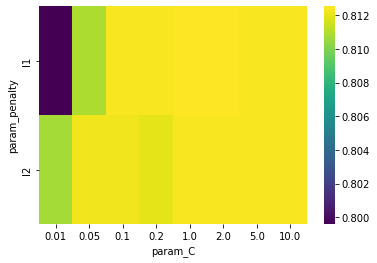

In [40]:
LR_models = pd.DataFrame(Grid_LR.cv_results_)
LR_res = (LR_models.pivot(index='param_penalty', columns='param_C', values='mean_test_score'))

_ = sns.heatmap(LR_res, cmap='viridis')

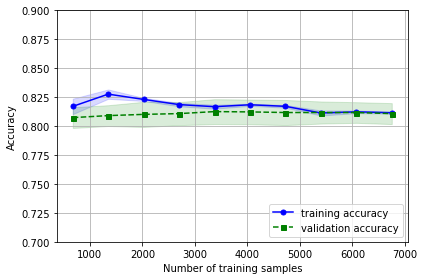

In [41]:
# learning curve

train_sizes, train_scores, test_scores = \
                learning_curve(estimator=LogisticRegression(penalty='l2', random_state = 0),
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)
                
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.7, 0.9])
plt.tight_layout()
plt.show()

### Part 3.2.2: Find Optimal Hyperparameters: KNN

In [42]:
# Possible hyperparamter options for KNN
# Choose k

parameters = {'n_neighbors':[1,3,5,7], 'weights': ['distance', 'uniform']}

Grid_KNN = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7],
                         'weights': ['distance', 'uniform']})

In [43]:
print_grid_search_metrics(Grid_KNN)

Best score: 0.8433333333333334
Best parameters set: 
n_neighbors:7
weights:distance


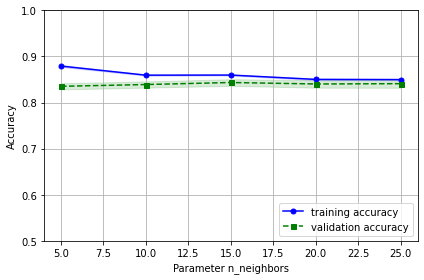

In [44]:
param_range = [5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
                estimator=KNeighborsClassifier(), 
                X=X_train, 
                y=y_train, 
                param_name='n_neighbors', 
                param_range=param_range,
                cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Parameter n_neighbors')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.tight_layout()

In [45]:
best_KNN_model = Grid_KNN.best_estimator_

In [46]:
prediction_best_KNN_model = best_KNN_model.predict(X_test)

In [47]:
print(classification_report(y_test, prediction_best_KNN_model))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1991
           1       0.70      0.39      0.50       509

    accuracy                           0.84      2500
   macro avg       0.78      0.67      0.70      2500
weighted avg       0.83      0.84      0.82      2500



In [48]:
best_KNN_model.score(X_test, y_test)

0.8404

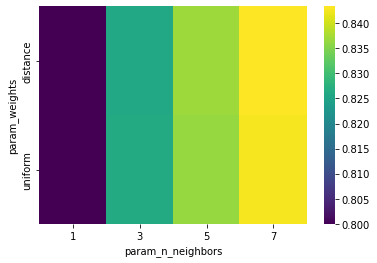

In [49]:
KNN_models = pd.DataFrame(Grid_KNN.cv_results_)
KNN_res = (KNN_models.pivot(index='param_weights', columns='param_n_neighbors', values='mean_test_score'))

_ = sns.heatmap(KNN_res, cmap='viridis')

### Part 3.2.3: Find Optimal Hyperparamters: Random Forest

In [50]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees

parameters = {
    'n_estimators' : [50,80,100, 200],
    'max_depth': [1,5,10,15]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10, 15],
                         'n_estimators': [50, 80, 100, 200]})

In [51]:
# best number of trees
print_grid_search_metrics(Grid_RF)

Best score: 0.8667999999999999
Best parameters set: 
max_depth:10
n_estimators:100


In [52]:
# best random forest model
best_RF_model = Grid_RF.best_estimator_
best_RF_model

RandomForestClassifier(max_depth=10)

In [53]:
prediction_best_RF_model = best_RF_model.predict(X_test)
print(classification_report(y_test, prediction_best_RF_model))

              precision    recall  f1-score   support

           0       0.86      0.97      0.92      1991
           1       0.80      0.40      0.54       509

    accuracy                           0.86      2500
   macro avg       0.83      0.69      0.73      2500
weighted avg       0.85      0.86      0.84      2500



In [54]:
best_RF_model.score(X_test, y_test)

0.8588

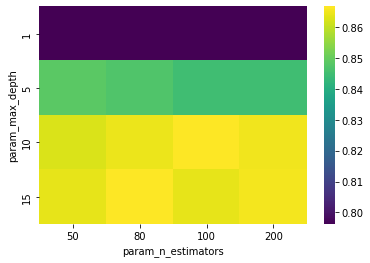

In [55]:
RF_models = pd.DataFrame(Grid_RF.cv_results_)
RF_res = (RF_models.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score'))

_ = sns.heatmap(RF_res, cmap='viridis')

### Part 3.2.4: Find Optimal Hyperparamters: XGBoost

In [56]:
# possible hyperparamters for XGBoost

params_xgb = {
        'learning_rate': [0.1, 0.5, 1],
        'n_estimators': [50, 100, 200],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 8]
        }

xgb = XGBClassifier(objective = 'binary:logistic', seed = 27, silent=True)
Grid_XGB = GridSearchCV(xgb, params_xgb, cv=5)
Grid_XGB.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(seed=27, silent=True),
             param_grid={'learning_rate': [0.1, 0.5, 1], 'max_depth': [3, 5, 8],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]})

In [57]:
print_grid_search_metrics(Grid_XGB)

Best score: 0.8687999999999999
Best parameters set: 
learning_rate:0.1
max_depth:3
min_child_weight:10
n_estimators:200
subsample:0.8


In [58]:
# best XGBoost model
best_XGB_model = Grid_XGB.best_estimator_
best_XGB_model

XGBClassifier(min_child_weight=10, n_estimators=200, seed=27, silent=True,
              subsample=0.8)

In [59]:
prediction_best_XGB_model = best_XGB_model.predict(X_test)
print(classification_report(y_test, prediction_best_XGB_model))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1991
           1       0.75      0.44      0.56       509

    accuracy                           0.86      2500
   macro avg       0.81      0.70      0.74      2500
weighted avg       0.85      0.86      0.84      2500



In [60]:
best_XGB_model.score(X_test, y_test)

0.8564

## Part 3.3: Model Evaluation - Confusion Matrix (Precission, Recall, Accuracy)

In [61]:
# UDF for print cofusion matrix

def cal_evluation(classifier, cm):
  tn = cm[0][0]
  fp = cm[0][1]
  fn = cm[1][0]
  tp = cm[1][1]
  accuracy = (tp +tn) / (tn + tp + fn + fp + 0.0)
  precision = tp / (tp + fp + 0.0)
  recall = tp / (tp + fn + 0.0)
  print(classifier)
  print('Accuracy is: ' + str(accuracy))
  print('precision is: ' + str(precision))
  print('recall is: ' + str(recall))
  print()

# print out confusion matrics
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evluation(classifier, cm)

In [62]:
# Confusion matrix, accuracy, precision and recall for random forest and logistic regression
confusion_matrices = [  
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("K nearest neighbor", confusion_matrix(y_test, best_KNN_model.predict(X_test))),
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("XGBoost", confusion_matrix(y_test, best_XGB_model.predict(X_test)))
    ]

draw_confusion_matrices(confusion_matrices)

Logistic Regression
Accuracy is: 0.8092
precision is: 0.5963855421686747
recall is: 0.1944990176817289

K nearest neighbor
Accuracy is: 0.8404
precision is: 0.6950354609929078
recall is: 0.3850687622789784

Random Forest
Accuracy is: 0.8588
precision is: 0.8046875
recall is: 0.40471512770137524

XGBoost
Accuracy is: 0.8564
precision is: 0.7483443708609272
recall is: 0.444007858546169



## Part 3.4: Model Evaluation - ROC & AUC

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function

In [63]:
# UDF model evaluation ROC & AUC

def roc_auc_fig_score(model, X_test, y_test, model_name):
    y_pred_model = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_model)
    print(metrics.auc(fpr, tpr))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve - RF model')
    plt.legend(loc='best')
    plt.show()

### Part 3.4.1: ROC of LR Model

roc_auc_score of Logistic Regression model is
0.772206757520828


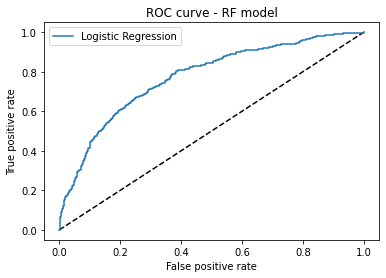

In [64]:
print("roc_auc_score of Logistic Regression model is")
roc_auc_fig_score(best_LR_model, X_test, y_test, 'Logistic Regression')

### Part 3.4.2: ROC of KNN Model

roc_auc_score of KNN model is
0.7899501588188103


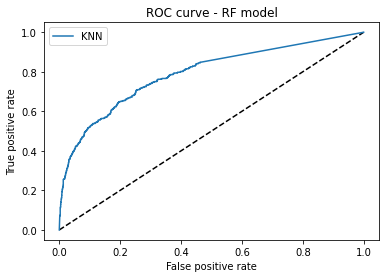

In [65]:
print("roc_auc_score of KNN model is")
roc_auc_fig_score(best_KNN_model, X_test, y_test, 'KNN')

### Part 3.4.3: ROC of RF Model

roc_auc_score of Random Forest model is
0.8481615205556634


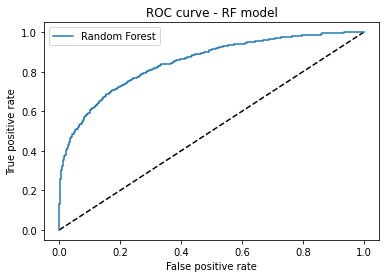

In [66]:
print("roc_auc_score of Random Forest model is")
roc_auc_fig_score(best_RF_model, X_test, y_test, 'Random Forest')

### Part 3.4.4: ROC of XGBoost Model

roc_auc_score of XGBoost model is
0.8485759592034489


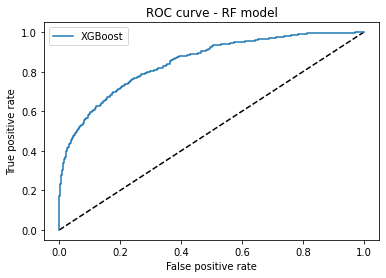

In [67]:
print("roc_auc_score of XGBoost model is")
roc_auc_fig_score(best_XGB_model, X_test, y_test, 'XGBoost')

# Part 4: Model Extra Functionality - Feature Importance

based on XGBoost model



## Part 4.1: XGBoost Model - Model Feature Importance

In [68]:
X_XGB = X.copy()

X_XGB = OneHotEncoding(X_XGB, enc_ohe, ['Geography'])
X_XGB['Gender'] = enc_oe.transform(X_XGB[['Gender']])

X_XGB.head()

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619     0.0   42       2       0.00              1          1   
1          608     0.0   41       1   83807.86              1          0   
2          502     0.0   42       8  159660.80              3          1   
3          699     0.0   39       1       0.00              2          0   
4          850     0.0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0               1        101348.88               1.0                0.0   
1               1        112542.58               0.0                0.0   
2               0        113931.57               1.0                0.0   
3               0         93826.63               1.0                0.0   
4               1         79084.10               0.0                0.0   

   Geography_Spain  
0              0.0  
1              1.0  
2              0.0  
3              0.0  
4              1.0

In [69]:
XGB = XGBClassifier()
XGB.fit(X_XGB, y)

importances_XGB = XGB.feature_importances_
indices = np.argsort(importances_XGB)[::-1]

print("Feature importance ranking by XGBoost Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X_XGB.columns[indices[ind]],round(importances_XGB[indices[ind]], 4)))

Feature importance ranking by XGBoost Model:
IsActiveMember : 0.22990000247955322
Age : 0.21299999952316284
NumOfProducts : 0.1754000037908554
Geography_Germany : 0.13670000433921814
Gender : 0.07540000230073929
Balance : 0.06069999933242798
Geography_France : 0.02539999969303608
CreditScore : 0.020999999716877937
EstimatedSalary : 0.020500000566244125
Tenure : 0.01889999955892563


In [70]:
# DataFrame of feature importance based on XGBoost model feature importance

XGB_feature_importance = pd.DataFrame(XGB.feature_importances_, index=X_train.columns, columns=['Feature Importance (XGB)'])
XGB_feature_importance = XGB_feature_importance.sort_values(by='Feature Importance (XGB)',ascending=False)
XGB_feature_importance

Feature Importance (XGB)
IsActiveMember                     0.229859
Age                                0.213001
NumOfProducts                      0.175391
Geography_Germany                  0.136736
Gender                             0.075449
Balance                            0.060670
Geography_France                   0.025417
CreditScore                        0.021017
EstimatedSalary                    0.020550
Tenure                             0.018933
HasCrCard                          0.015236
Geography_Spain                    0.007743

## Part 4.2: XGBoost Permutation Feature Importance

In [71]:
# evalualte feature importance with permutaiton feature importance

XGB_PI = permutation_importance(best_XGB_model, X_test, y_test, n_repeats=5, random_state=1)

XGB_PI_res = pd.DataFrame(data=np.transpose([XGB_PI['importances_mean'],XGB_PI['importances_std']]), 
             index = X_test.columns,columns=['PI_mean','PI_std'])
XGB_PI_res = XGB_PI_res.sort_values(by='PI_mean',ascending=False)
XGB_PI_res

PI_mean    PI_std
Age                0.06976  0.003547
NumOfProducts      0.05128  0.002046
IsActiveMember     0.02368  0.003445
Geography_Germany  0.00776  0.000824
Balance            0.00672  0.000688
Gender             0.00176  0.002354
EstimatedSalary    0.00040  0.002205
Geography_Spain   -0.00024  0.000480
CreditScore       -0.00040  0.001640
HasCrCard         -0.00048  0.000688
Geography_France  -0.00064  0.001031
Tenure            -0.00168  0.001462

## Part 4.3: XGBoost SHAP Value Feature Importance

In [72]:
# evalulate feature importance base on SHAP value

shap_XGB = best_XGB_model.fit(X_test, y_test)

In [73]:
XGB_explainer = shap.TreeExplainer(best_XGB_model)

XGB_shap_values = XGB_explainer(X_test)

In [74]:
shap.initjs()
shap.plots.force(XGB_shap_values[0])

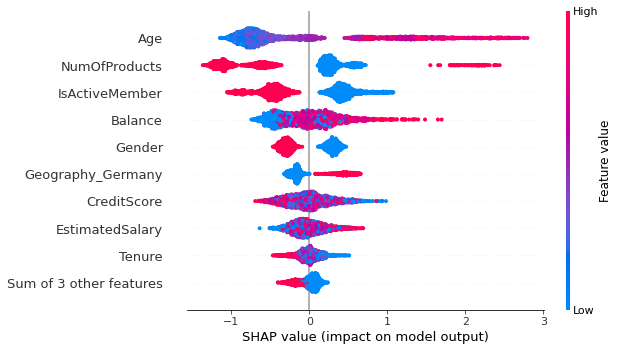

In [75]:
shap.plots.beeswarm(XGB_shap_values)

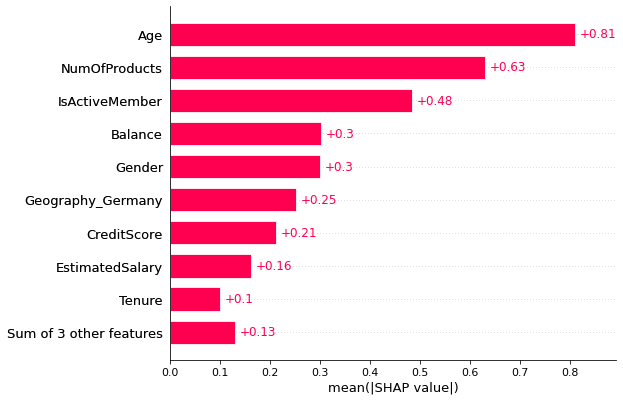

In [76]:
shap.plots.bar(XGB_shap_values)

In [77]:
XGB_feature_names = list(X_test.columns.values)
vals = np.abs(XGB_shap_values.values).mean(0)
XGB_SHAP_importance = pd.DataFrame(list(zip(XGB_feature_names, vals)), columns=['col_name','feature_importance_vals'])
XGB_SHAP_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
XGB_SHAP_importance

col_name  feature_importance_vals
2                 Age                 0.809904
5       NumOfProducts                 0.629055
7      IsActiveMember                 0.484537
4             Balance                 0.302313
1              Gender                 0.299249
10  Geography_Germany                 0.251363
0         CreditScore                 0.212485
8     EstimatedSalary                 0.160930
3              Tenure                 0.099571
11    Geography_Spain                 0.057792
9    Geography_France                 0.046433
6           HasCrCard                 0.026081

## Part 4.4 Summary of Feature Importance

In [78]:
summary_Feature_importance = pd.DataFrame({
               'Model Feature Importance':list(XGB_feature_importance.index),
               'Permutation Importance':list(XGB_PI_res.index),
               'SHAP Importance':list(XGB_SHAP_importance.col_name)})
summary_Feature_importance

Model Feature Importance Permutation Importance    SHAP Importance
0            IsActiveMember                    Age                Age
1                       Age          NumOfProducts      NumOfProducts
2             NumOfProducts         IsActiveMember     IsActiveMember
3         Geography_Germany      Geography_Germany            Balance
4                    Gender                Balance             Gender
5                   Balance                 Gender  Geography_Germany
6          Geography_France        EstimatedSalary        CreditScore
7               CreditScore        Geography_Spain    EstimatedSalary
8           EstimatedSalary            CreditScore             Tenure
9                    Tenure              HasCrCard    Geography_Spain
10                HasCrCard       Geography_France   Geography_France
11          Geography_Spain                 Tenure          HasCrCard